Notebook for plotting behavior before and after iso anesthesia.

In [6]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
#     assert False, 'plot_dir not yet implemented on Nat laptop'
    plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

from Anesthesia.behavior import Alternation

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in behavioral data

In [15]:
behave_files

[PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Finn/2022_01_31_alternation1/Finn_alternation1_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Finn/2022_02_01_alternation2/Finn_alternation2_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Finn/2022_02_03_alternation3/Finn_alternation3_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Finn/2022_02_04_alternation4/Finn_alternation4_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Finn/2022_02_08_alternation5/Finn_alternation5_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Rat698/2021_07_08/Rat698_alternation1_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats/Rat698/2021_07_10/Rat698_alternation2_behavior.csv'),
 PosixPath('/Users/nkinsky/Documents/UM/Working/Alte

In [16]:
if platform.system() == "Darwin": # Nat laptop
    base_dir = Path("/Users/nkinsky/Documents/UM/Working/Alternation/Recording_Rats")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        base_dir = Path("/data2/Alternation/Recording_Rats")

behave_files = sorted(base_dir.glob("**/*behavior.csv"))
behave_all_df = []
for file in behave_files:
    behave_df = Alternation.get_behavioral_data(file)

    # Make columns booleans
    behave_df["Correct"] = (behave_df["Correct"] == "Y").astype(int)
    behave_df["VTE"] = (behave_df["VTE"] == "Y").astype(int)

    # Load in VTE before / after data
    behave_df.loc[0:(behave_df.shape[0] - 2), "VTE follows"] = behave_df.loc[1:, "VTE"].values
    behave_df.loc[behave_df.shape[0], "VTE follows"] = np.nan

    behave_df.loc[1:(behave_df.shape[0] - 1), "VTE precedes"] = behave_df.loc[:(behave_df.shape[0] - 2), "VTE"].values
    behave_df.loc[behave_df.shape[0], "VTE precedes"] = np.nan
    
    behave_all_df.append(behave_df)

behave_all_df = pd.concat(behave_all_df, axis=0, ignore_index=True)
# behave_all_df["Correct"] = behave_all_df["Correct"] == "Y"
# behave_all_df["VTE"] = behave_all_df["VTE"] == "Y"
behave_all_df

,Trial,Choice,Correct,VTE,Animal,Session,VTE follows,VTE precedes
0,1.0,R,1.0,0.0,Finn,Alternation1,0.0,NaN
1,2.0,R,0.0,0.0,Finn,Alternation1,1.0,0.0
2,3.0,L,1.0,1.0,Finn,Alternation1,0.0,0.0
3,4.0,L,0.0,0.0,Finn,Alternation1,0.0,1.0
4,5.0,R,1.0,0.0,Finn,Alternation1,1.0,0.0
...,...,...,...,...,...,...,...,...
675,28.0,L,0.0,0.0,Rose,Alternation5,0.0,1.0
676,29.0,R,1.0,0.0,Rose,Alternation5,0.0,0.0
677,30.0,L,1.0,0.0,Rose,Alternation5,NaN,0.0
678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Quantify # trials per session

mean = Trial    28.675
dtype: float64 trials
mean sem = Trial    6.752359
dtype: float64 trials


<Axes: xlabel='Session', ylabel='Trial'>

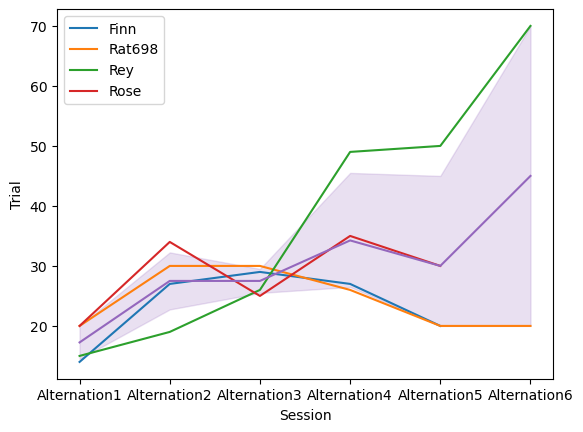

In [44]:
trial_count_df = behave_all_df.groupby(["Animal", "Session"]).count().drop(columns=["Choice", "Correct", "VTE", "VTE follows", "VTE precedes"]).reset_index()
print(f"mean = {trial_count_df.groupby('Animal').mean(numeric_only=True).mean()} trials")
print(f"mean sem = {trial_count_df.groupby('Animal').mean(numeric_only=True).std()} trials")

_, ax = plt.subplots()
sns.lineplot(data=trial_count_df, x="Session", y="Trial", hue="Animal", ax=ax)
sns.lineplot(data=trial_count_df, x="Session", y="Trial", ax=ax)


#### Look at after chucking learning days (1-2)

In [47]:
master_count_df

Trial    32.020833
dtype: float64

In [48]:
master_count_df = trial_count_df[~np.isin(trial_count_df.Session, ["Alternation1", "Alternation2"])]
print(f"mean = {master_count_df.groupby('Animal').mean(numeric_only=True).mean()} trials")
print(f"mean sem = {master_count_df.groupby('Animal').mean(numeric_only=True).std()} trials")

mean = Trial    32.020833
dtype: float64 trials
mean sem = Trial    11.445599
dtype: float64 trials


## Plot behavior across all animals
Note that 1st session for all animals only contains a small number of trials. So while they perform ok, they can't do the task for very long.

/tmp/ipykernel_1122438/3639184717.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([txt.get_text()[-1] for txt in ax.get_xticklabels()])


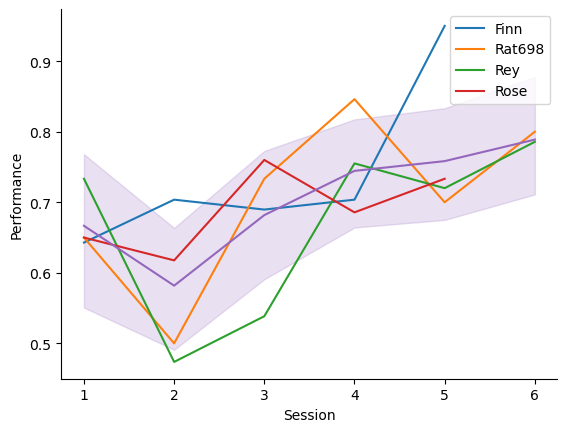

In [118]:
figperf, ax = plt.subplots()
animal_mean = behave_all_df.groupby(["Animal", "Session"]).mean(numeric_only=True).reset_index()
group_mean = behave_all_df.groupby(["Session"]).mean(numeric_only=True).reset_index()
sns.lineplot(data=animal_mean, x="Session", y="Correct", hue="Animal", ax=ax)
sns.lineplot(data=behave_all_df, x="Session", y="Correct", ax=ax)
ax.set_ylabel("Performance")
ax.set_xticklabels([txt.get_text()[-1] for txt in ax.get_xticklabels()])
sns.despine(ax=ax)

figperf.savefig(plot_dir / "Alternation_performance.pdf")

## Plot VTEs versus session

/tmp/ipykernel_1122438/2934366545.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([txt.get_text()[-1] for txt in ax.get_xticklabels()])


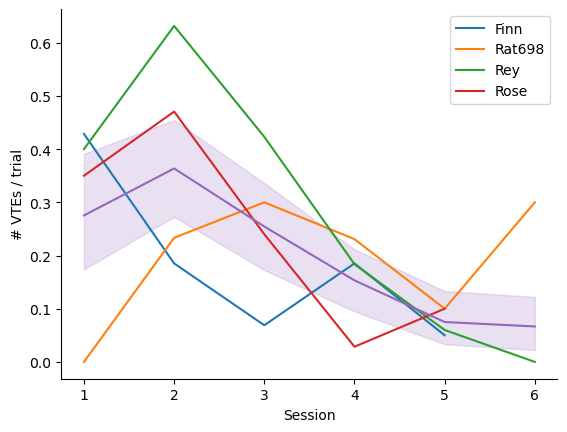

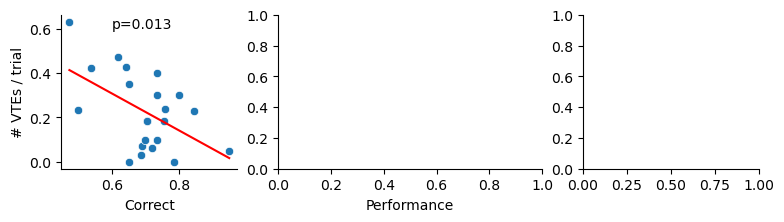

In [184]:
figVTE, ax = plt.subplots()
sns.lineplot(data=animal_mean, x="Session", y="VTE", hue="Animal", ax=ax)
sns.lineplot(data=behave_all_df, x="Session", y="VTE", ax=ax)
ax.set_ylabel("# VTEs / trial")
ax.set_xticklabels([txt.get_text()[-1] for txt in ax.get_xticklabels()])
sns.despine(ax=ax)

figVTE.savefig(plot_dir / "VTE_vs_session.pdf")

In [237]:
# Split up by animal and by correct v in correct trials
vte_follow_mean = behave_all_df[behave_all_df["VTE follows"] == 1].groupby(["Animal", "Session"]).mean(numeric_only=True)
vte_precede_mean = behave_all_df[behave_all_df["VTE precedes"] == 1].groupby(["Animal", "Session"]).mean(numeric_only=True)
vte_win_one_mean = behave_all_df[(behave_all_df["VTE follows"] == 1) | (behave_all_df["VTE precedes"] == 1)].groupby(["Animal", "Session"]).mean(numeric_only=True).reset_index()

behave_all_df["VTE +/- 1 trial"] = (behave_all_df["VTE"] == 1) | (behave_all_df["VTE precedes"] == 1) | (behave_all_df["VTE follows"] == 1)

error_mean = behave_all_df[behave_all_df.Correct == 0].groupby(["Animal"]).mean(numeric_only=True).reset_index()
correct_mean = behave_all_df[behave_all_df.Correct == 1].groupby(["Animal"]).mean(numeric_only=True).reset_index()
split_mean = pd.concat((correct_mean, error_mean), axis=0, ignore_index=True)

/tmp/ipykernel_1122438/1146708219.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([txt.get_text()[-1] for txt in ax[1].get_xticklabels()])
/tmp/ipykernel_1122438/1146708219.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(["Correct", "Error"])
/tmp/ipykernel_1122438/1146708219.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=behave_all_df, x="Session", y="Correct", palette=sns.color_palette()[2:], ax=ax2)
/tmp/ipykernel_1122438/1146708219.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([txt.get_text()[-1] for txt in ax2.get_xticklabels()])


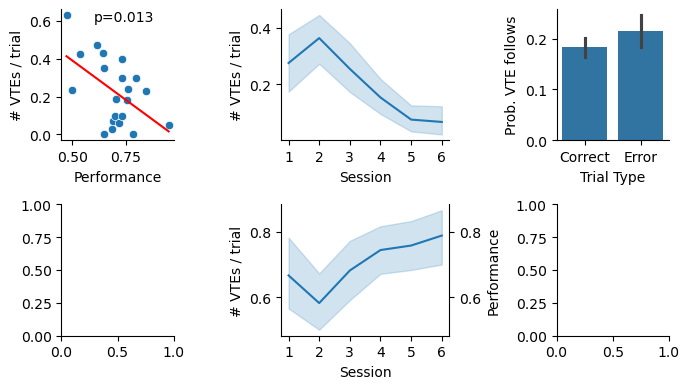

In [258]:
figVTE_v_perf, axs = plt.subplots(2, 3, figsize=(7, 4), width_ratios=(2, 3, 2), layout="tight")

ax = axs[0]
sns.scatterplot(data=animal_mean, x="Correct", y="VTE", ax=ax[0])
linfit = pg.linear_regression(animal_mean["Correct"], animal_mean["VTE"])
xlims = np.array((animal_mean.Correct.min(), animal_mean.Correct.max()))
ax[0].plot(xlims, xlims * linfit[linfit.names == "Correct"].coef.values + linfit[linfit.names == "Intercept"].coef.values, 'r-')
ax[0].text(0.6, 0.6, f"p={linfit[linfit.names == 'Correct'].pval.values[0]:.3f}")
ax[0].set_ylabel("# VTEs / trial")
ax[0].set_xlabel("Performance")

sns.lineplot(data=behave_all_df, x="Session", y="VTE", ax=ax[1])
ax[1].set_ylabel("# VTEs / trial")
ax[1].set_xticklabels([txt.get_text()[-1] for txt in ax[1].get_xticklabels()])

sns.barplot(data=behave_all_df, x= "Correct", y="VTE follows", order=(1.0, 0.0), errorbar="se", ax=ax[2])
ax[2].set_xticklabels(["Correct", "Error"])
ax[2].set_xlabel("Trial Type")
ax[2].set_ylabel("Prob. VTE follows")

sns.despine(fig=figVTE_v_perf)

# Now plot performance to overlay manually on VTE plot
ax2 = axs[1, 1]
ax2b = ax2.secondary_yaxis('right', functions=(lambda x: x, lambda x2: x2))

sns.lineplot(data=behave_all_df, x="Session", y="Correct", palette=sns.color_palette()[2:], ax=ax2)
ax2b.set_ylabel("Performance")

ax2.set_ylabel("# VTEs / trial")
ax2b.set_xticklabels([txt.get_text()[-1] for txt in ax2b.get_xticklabels()])
ax2.set_xticklabels([txt.get_text()[-1] for txt in ax2.get_xticklabels()])

figVTE_v_perf.savefig(plot_dir / "VTE_v_performance.pdf")
